In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import pyro
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from cometml_api import api
from bb_opt.src.bayesian_opt import (
    normal_priors, normal_variationals,
    spike_slab_priors, SpikeSlabNormal,
    make_bnn_model, make_guide,
    train, bnn_predict, optimize,
    get_model_bnn, acquire_batch_ei, train_model_bnn,
    get_model_nn, acquire_batch_nn_greedy, train_model_nn
)
from bb_opt.src.utils import jointplot, load_data, save_pyro_model, load_pyro_model
from gpu_utils.utils import gpu_init

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 100

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on GPU 0


# Predictive Performance

In [4]:
data_root = "/cluster/nhunt/github/bb_opt/data"
project = "dna_binding"
dataset = "crx_ref_r1"

n_train = 1000
n_val = 100
normalized = True

data = load_data(data_root, project, dataset, n_train, n_val, standardize_labels=normalized, device=device)

/cluster/nhunt/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
n_hidden = 100
non_linearity = 'ReLU'
n_inputs = data.train.inputs.shape[1]

model = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, 1)
).to(device)

## Deterministic NN

In [6]:
train_loader = DataLoader(
    TensorDataset(data.train.inputs, data.train.labels),
    batch_size=batch_size,
    shuffle=True
)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()

In [12]:
train_losses = []
test_losses = []

for epoch in range(300):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        predictions = model(inputs).squeeze()
        loss = loss_func(predictions, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        predictions = model(data.test.inputs).squeeze()
        test_loss = loss_func(predictions, data.test.labels)
        test_losses.append(test_loss.item())

#     if epoch % 5 == 0:
#         print(f'[E{epoch}] Loss = {loss.item():.3f}. Val loss = {test_loss.item():.3f}')

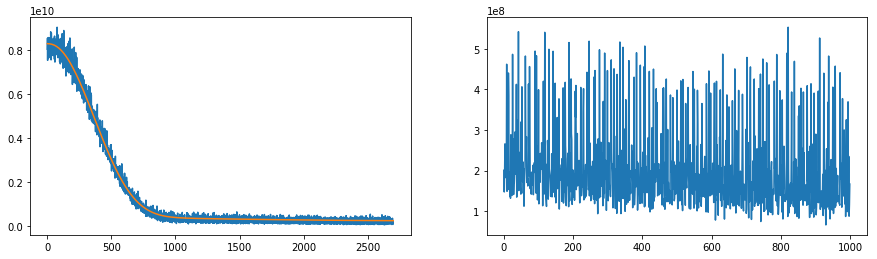

In [15]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(train_losses)
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses)

plt.subplot(122)
plt.plot(train_losses[-1000:])

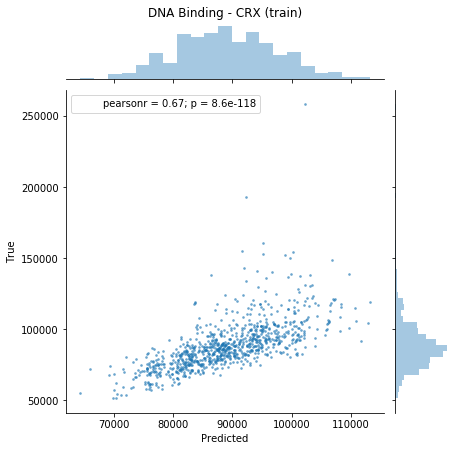

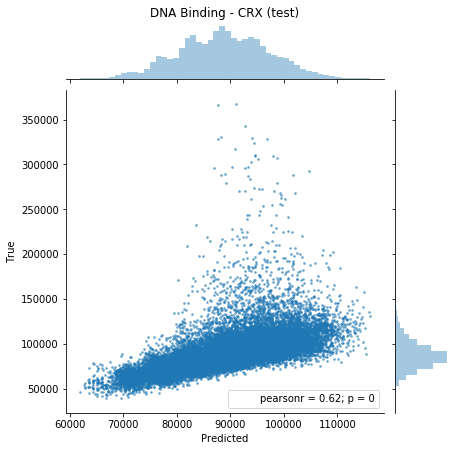

In [17]:
title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

jointplot(model(data.train.inputs).squeeze(), data.train.labels, title=train_title)
jointplot(predictions, data.test.labels, title=test_title)

## BNN

In [6]:
n_samples = 10
prior_mean = 0
prior_std = 1

priors = lambda: normal_priors(model, prior_mean, prior_std)
# priors = lambda: spike_slab_priors(model, std2=1.5)
variationals = lambda: normal_variationals(model, prior_mean, prior_std)
bnn_model = make_bnn_model(model, priors, batch_size=batch_size)
guide = make_guide(model, variationals)
# guide = AutoDiagonalNormal(model)

optimizer = pyro.optim.Adam({'lr': 0.01})
pyro.clear_param_store()
svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

losses = []
train_corrs = []
test_corrs = []
best_train_corrs = []
best_test_corrs = []

In [ ]:
for _ in range(85):
    losses += train(svi, 1000, data.train.inputs, data.train.labels, verbose=True)

    preds = bnn_predict(guide, data.train.inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, data.train.labels)[0])

    preds = bnn_predict(guide, data.test.inputs, n_samples=50).mean(axis=0)
    test_corrs.append(kendalltau(preds, data.test.labels)[0])

    _, sorted_idx = data.train.labels.sort(descending=True)
    n_10_percent = int(len(data.train.labels) * .1)

    preds = bnn_predict(guide, data.train.inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
    best_train_corrs.append(kendalltau(preds, data.train.labels[sorted_idx][:n_10_percent])[0])

    _, sorted_idx = data.test.labels.sort(descending=True)
    n_10_percent = int(len(data.test.labels) * .1)

    preds = bnn_predict(guide, data.test.inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
    best_test_corrs.append(kendalltau(preds, data.test.labels[sorted_idx][:n_10_percent])[0])

[S0000] loss: 1,329,959


In [ ]:
model_path = f"/cluster/nhunt/github/bb_opt/models_nathan/crx_{len(train_inputs)}_{len(train_corrs)}{'_n' if normalized else ''}"
# save_pyro_model(model_path, optimizer)

In [7]:
model_path = "/cluster/nhunt/github/bb_opt/models_nathan/crx_900_85_n"
load_pyro_model(model_path, optimizer)

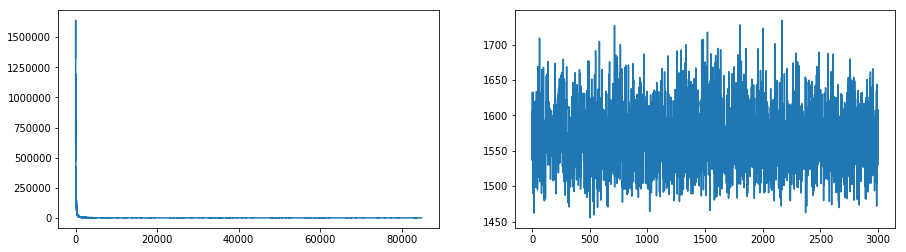

In [7]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.subplot(122)
plt.plot(losses[-3000:])
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

/cluster/nhunt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


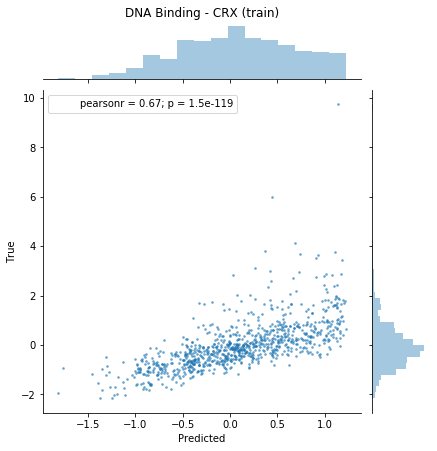

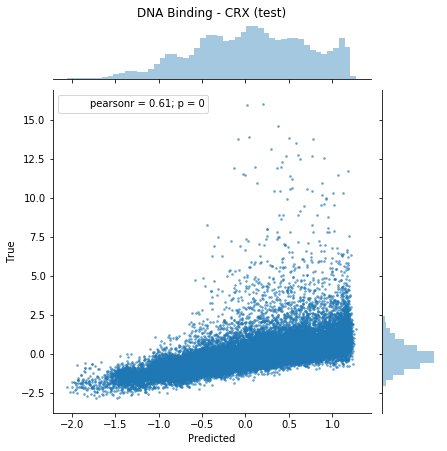

In [8]:
title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

preds = bnn_predict(guide, data.train.inputs, n_samples=50).mean(axis=0)
ax = jointplot(preds, data.train.labels, title=train_title)

preds = bnn_predict(guide, data.test.inputs, n_samples=50).mean(axis=0)
jointplot(preds, data.test.labels, title=test_title)

/cluster/nhunt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


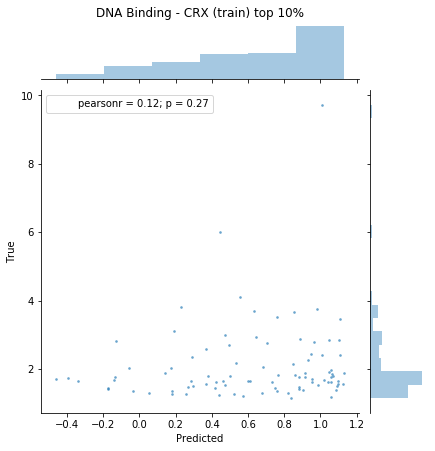

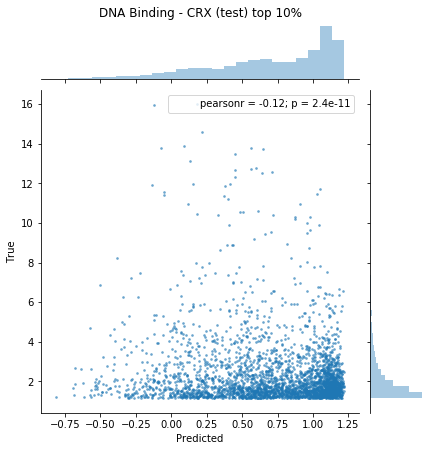

In [9]:
_, sorted_idx = data.train.labels.sort(descending=True)
n_10_percent = int(len(data.train.labels) * .1)

preds = bnn_predict(guide, data.train.inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
jointplot(preds, data.train.labels[sorted_idx][:n_10_percent], title=train_title + " top 10%")

_, sorted_idx = data.test.labels.sort(descending=True)
n_10_percent = int(len(data.test.labels) * .1)

preds = bnn_predict(guide, data.test.inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
jointplot(preds, data.test.labels[sorted_idx][:n_10_percent], title=test_title + " top 10%")

In [10]:
plt.rcParams["figure.facecolor"] = "white"

Text(0.5,1,'Kendall Tau')

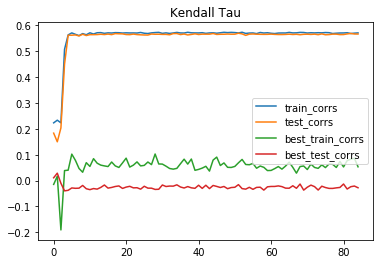

In [12]:
plt.plot(train_corrs, label="train_corrs")
plt.plot(test_corrs, label="test_corrs")
plt.plot(best_train_corrs, label="best_train_corrs")
plt.plot(best_test_corrs, label="best_test_corrs")
plt.legend()
plt.title("Kendall Tau")

In [13]:
max(test_corrs), test_corrs[-1]

(0.5690710814956311, 0.565861379738086)

In [14]:
np.argmax(test_corrs), np.argmax(best_test_corrs)

(51, 1)

In [15]:
max(best_test_corrs), best_test_corrs[-1], best_test_corrs[np.argmax(test_corrs)]

(0.028676126753538422, -0.02767596602734034, -0.015657710501340967)

## Calibration

In [19]:
preds = bnn_predict(guide, data.test.inputs, n_samples=1000)

train_inputs = data.train.inputs.cpu().numpy()
inputs = data.test.inputs.cpu().numpy()
labels = data.test.labels.cpu().numpy()

In [178]:
from bb_opt.src.diagnostic_plots import diagnostic_plots, plot_preds_with_conf_intervals

In [190]:
preds.shape, labels.shape

((1000, 31896), (31896,))

In [200]:
n_subsample = 1000
subsample_idx = np.random.choice(range(len(labels)), size=n_subsample, replace=False)

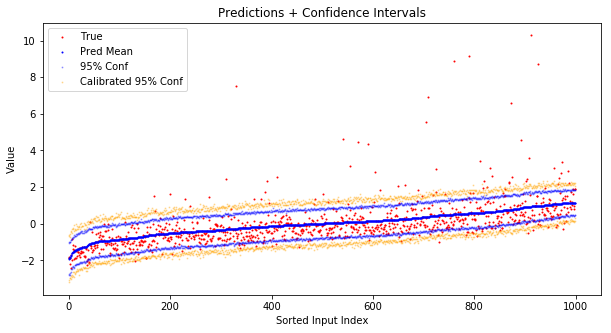

In [213]:
plot_preds_with_conf_intervals(preds[:, subsample_idx], labels[subsample_idx])

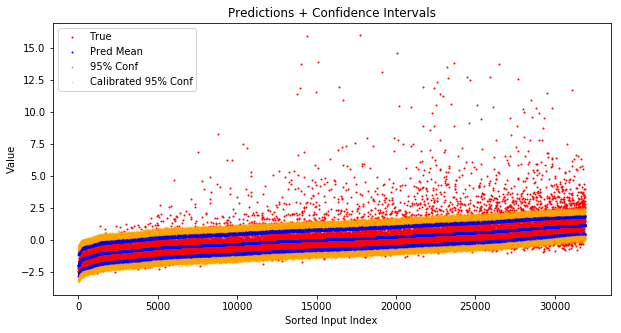

In [214]:
plot_preds_with_conf_intervals(preds, labels)

In [208]:
labels.min(), labels.max(), labels.mean()

(-2.8386652, 15.972702, 0.0022871534)

In [209]:
preds.min(), preds.max(), preds.mean()

(-3.6600766, 3.1282523, 0.037679095)

/cluster/nhunt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


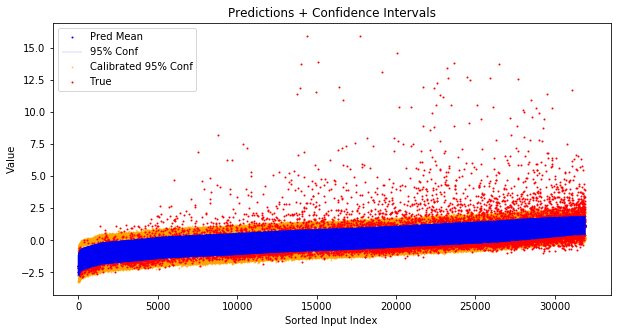

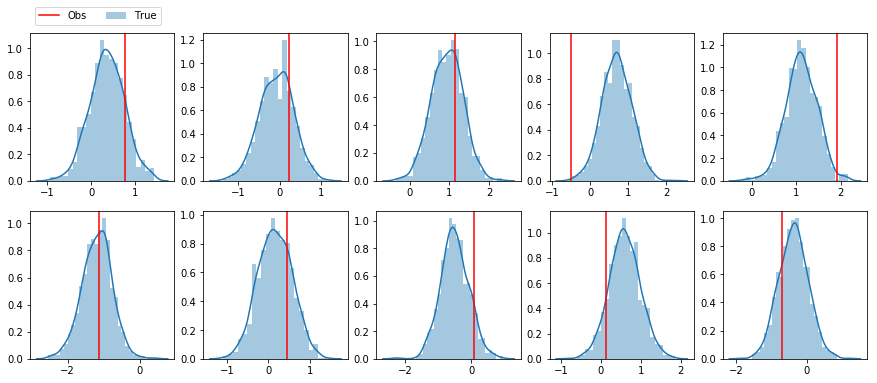

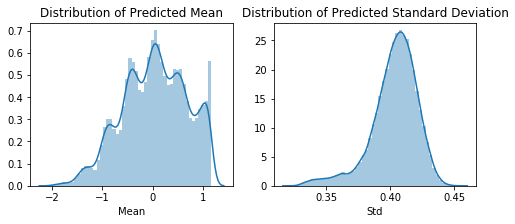

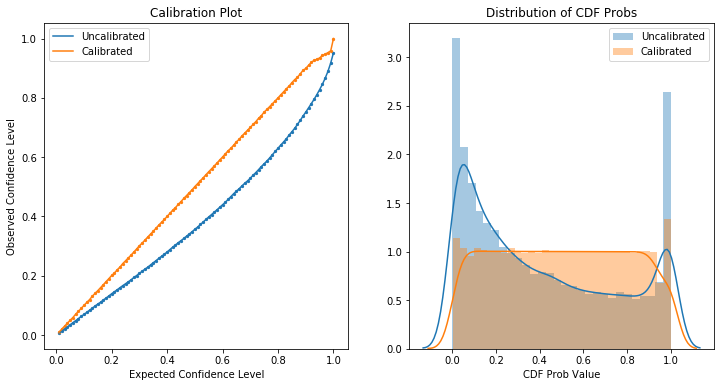

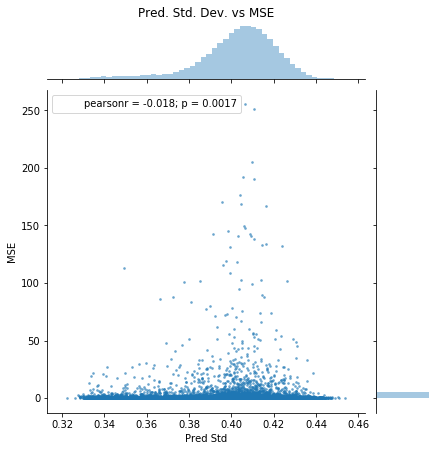

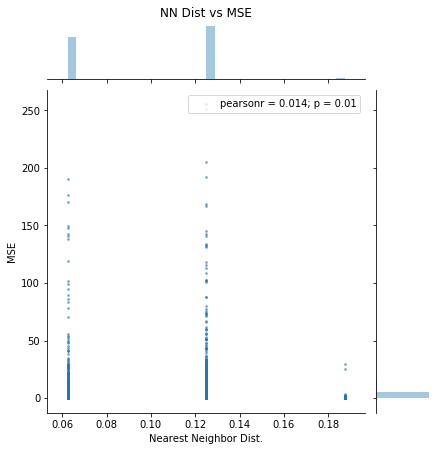

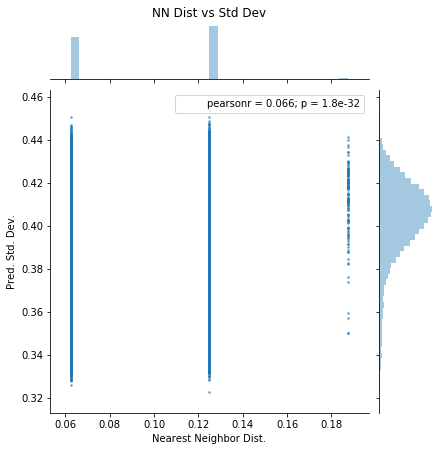

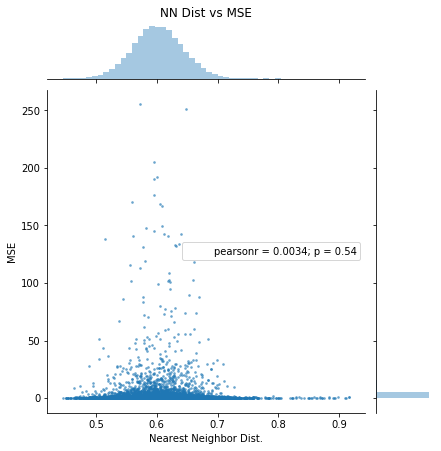

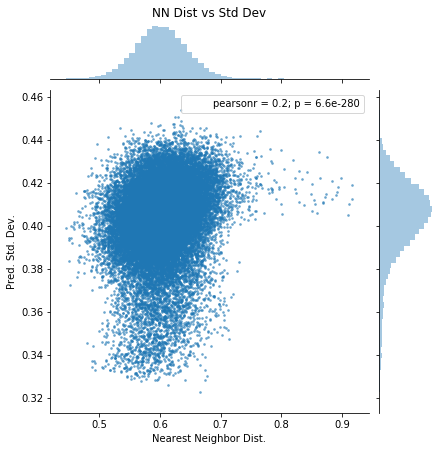

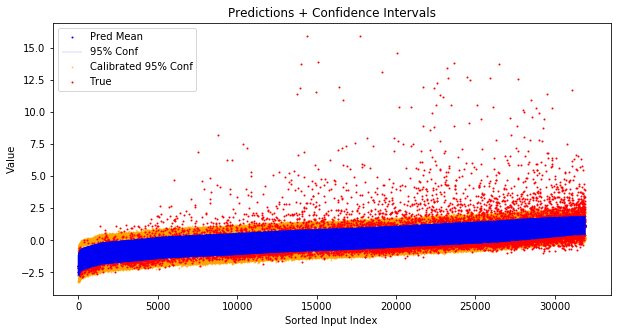

In [188]:
conf_level = 0.95
diagnostic_plots(inputs, train_inputs, preds, labels, conf_level, guide)

* Count how often points show up in the distribution over the max input
* See whether the point you select (for batch size one) shows up (and how much, compared to the most)
* Incremental training
  * How many steps? Do some testing?
* UCB
* EI - this is BNN greedy, right?

* Why is HSIC worse than uniform sampling?

# Some Plots

In [2]:
project_ids = api.get_project_names_and_ids("neighthan")
project_ids

{'bb-opt': 'b667ae9ddd1f42648260c89368afe1e4',
 'enrichment': 'bc3f0db9fd8c42e494eae720decb49d1',
 'evo': 'cf4ffd56df0c496ebbe6f9a1c55e6afa',
 'general': 'neighthan-NA'}

In [17]:
query_params = {'project': 'dna_binding'}
experiment_keys = api.get_experiments_with_params(project_ids["bb-opt"], query_params)

In [18]:
best_value = {}
for key in experiment_keys:
    params = api.get_params(key)
    metrics = api.get_metrics(key)
    
    name = params["save_key"]
    if name in best_value:
        best_value[name].append(metrics["best_value"].value.values)
    else:
        best_value[name] = [metrics["best_value"].value.values]

In [19]:
median = np.median(values, axis=0)
lower = np.percentile(values, 25, axis=0)
upper = np.percentile(values, 75, axis=0)

In [20]:
# handle mean and std as well as mean + explicit lower and upper error bounds
def plot_with_error(plot_data: Dict[str, Sequence[np.ndarray]]):
    for name, (mean, std) in plot_data.items():
        plt.plot(mean, label=name)
        plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.5)
    plt.legend()

In [21]:
bv = {}
for key, values in best_value.items():
    values = np.stack(values)[:, :30]
    print(key, len(values))
    bv[key] = (values.mean(0), values.std(0))

uniform 6
uniform 2x 6
nn 6
pdts 2
bnn 3
hsic 2


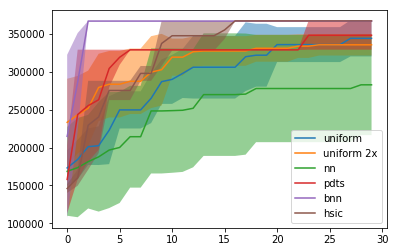

In [22]:
plot_with_error(bv)

In [23]:
best_value = {}
for key in experiment_keys:
    params = api.get_params(key)
    metrics = api.get_metrics(key)
    
    name = params["save_key"]
    if name in best_value:
        best_value[name].append(metrics["fraction_best"].value.values)
    else:
        best_value[name] = [metrics["fraction_best"].value.values]

In [24]:
bv = {}
for key, values in best_value.items():
    values = np.stack(values)
    print(key, len(values))
    bv[key] = (values.mean(0), values.std(0))

uniform 6
uniform 2x 6
nn 6
pdts 2
bnn 3
hsic 2


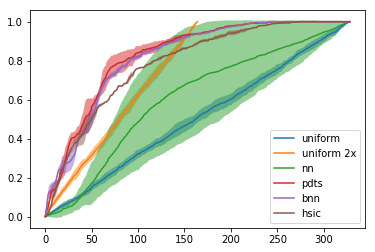

In [25]:
plot_with_error(bv)

* Set things to run only for 30-ish batches instead of the full 300?
  * That will make it fast for comparison w/ Tatsu, but it will mean we can't see the end of the fraction_best or similar metrics (though PDTS didn't show the end of it either)
* Draw samples PDTS-style, but maybe 10x as many, then subselect the batch based on HSIC
* Do MI-HSIC but only for a batch size of 1
* Do just mean/std without - lambda * HSIC ?